In [1]:
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
log_file = open("../logs/davinci_default_run.log", "r")
log_lines = log_file.readlines() # this ignores empty lines

In [3]:
removed_lines = 0

for line in log_lines:
    if "parse_model_output" in line or not line.startswith("2022-"):
        removed_lines += 1
        log_lines.remove(line)


print(f"Log has {len(log_lines)} lines after cleaning")
print(f"Removed lines: {removed_lines}")

Log has 34329 lines after cleaning
Removed lines: 24899


In [4]:
prediction_info = []
empty_key_dict = {
    "Address (post town)": None,
    "Address (post code)": None,
    "Address (street)": None,
    "Charity Name": None,
    "Charity Number": None,
    "Annual Income": None,
    "Period End Date": None,
    "Annual Spending": None,
}

for line in log_lines:
    if "Predicting document" in line: # this is the beginning of a prediction
        # create a new dictionary for this document
        prediction_info.append({
            "num_subdocs": None,
            "num_unifications": 0,
            "collision_per_key": empty_key_dict.copy(),
            "full_collision_per_key": empty_key_dict.copy(),
            "num_unified_values_per_key": empty_key_dict.copy(),
            "collision_percentage": None,
            "full_collision_percentage": None,
        })

    elif "Final prediction for document" in line: # this is the end of a prediction
        # calculate the percentages
        prediction_info[-1]["collision_percentage"] = np.mean([x for x in prediction_info[-1]["collision_per_key"].values() if x is not None])
        prediction_info[-1]["full_collision_percentage"] = np.mean([x for x in prediction_info[-1]["full_collision_per_key"].values() if x is not None])
 
    elif "No subdocs necessary" in line:
        prediction_info[-1]["num_subdocs"] = 1

    elif "Split document into" in line:
        num_subdocs = int(re.search("into (\d+) subdocuments", line).group(1))
        prediction_info[-1]["num_subdocs"] = num_subdocs

    elif "Unification necessary for key" in line:
        key = re.search("Unification necessary for key (.*)", line).group(1)
        prediction_info[-1]["collision_per_key"][key] = False
        prediction_info[-1]["full_collision_per_key"][key] = False
        values = re.search("Unifying \d+ \(lowered\) values (.*)", log_lines[log_lines.index(line)+1]).group(1)

        # values is the string representation of a list, so we can use eval to turn it into a list
        values = eval(values)
        unified_values = int(re.search("Unifying (\d+) \(lowered\) values", log_lines[log_lines.index(line)+1]).group(1))

        assert unified_values == len(values) # sanity check

        # if there is more than 1 value, then it's a unification
        if len(values) > 1:
            prediction_info[-1]["num_unifications"] += 1

            # if there are more than 1 different values, then it's a collision
            if len(set(values)) > 1:
                prediction_info[-1]["collision_per_key"][key] = True

            # if the length of the set is equal to the length of the list, then it's a full collision
            if len(set(values)) == len(values):
                prediction_info[-1]["full_collision_per_key"][key] = True

        if unified_values == 1: # not a unification
            prediction_info[-1]["num_unified_values_per_key"][key] = 0
        else:
            prediction_info[-1]["num_unified_values_per_key"][key] = unified_values

df = pd.DataFrame(prediction_info)
df.head()

/Users/ivo/Library/Caches/pypoetry/virtualenvs/uni-kie-JrmAaldC-py3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ivo/Library/Caches/pypoetry/virtualenvs/uni-kie-JrmAaldC-py3.8/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,num_subdocs,num_unifications,collision_per_key,full_collision_per_key,num_unified_values_per_key,collision_percentage,full_collision_percentage
0,1,0,"{'Address (post town)': None, 'Address (post c...","{'Address (post town)': None, 'Address (post c...","{'Address (post town)': None, 'Address (post c...",NaN,NaN
1,9,8,"{'Address (post town)': True, 'Address (post c...","{'Address (post town)': True, 'Address (post c...","{'Address (post town)': 4, 'Address (post code...",1.000,0.75
2,8,8,"{'Address (post town)': True, 'Address (post c...","{'Address (post town)': False, 'Address (post ...","{'Address (post town)': 5, 'Address (post code...",1.000,0.50
3,2,2,"{'Address (post town)': False, 'Address (post ...","{'Address (post town)': False, 'Address (post ...","{'Address (post town)': 0, 'Address (post code...",0.250,0.25
4,3,8,"{'Address (post town)': True, 'Address (post c...","{'Address (post town)': True, 'Address (post c...","{'Address (post town)': 2, 'Address (post code...",0.875,0.75


In [5]:
# add column "no_collision_percentage" which is the percentage of keys that had no collision
df["no_collision_percentage"] = 1 - df["collision_percentage"]

for i, row in df.iterrows():
    num_keys = len([x for x in row["collision_per_key"].values() if x is not None])
    num_no_collisions = len([x for x in row["collision_per_key"].values() if x is False])
    try:
        df.at[i, "no_collision_percentage_calculated"] = num_no_collisions / num_keys
    except ZeroDivisionError:
        df.at[i, "no_collision_percentage_calculated"] = np.nan

assert np.allclose(df["collision_percentage"], 1 - df["no_collision_percentage_calculated"], equal_nan=True) # sanity check

In [6]:
print(f"Number of predictions: {len(df)}")

Number of predictions: 440


In [7]:
print(f"Number of documents that were split into >1 subdocuments: {len(df[df['num_subdocs'] > 1])}")

Number of documents that were split into >1 subdocuments: 342


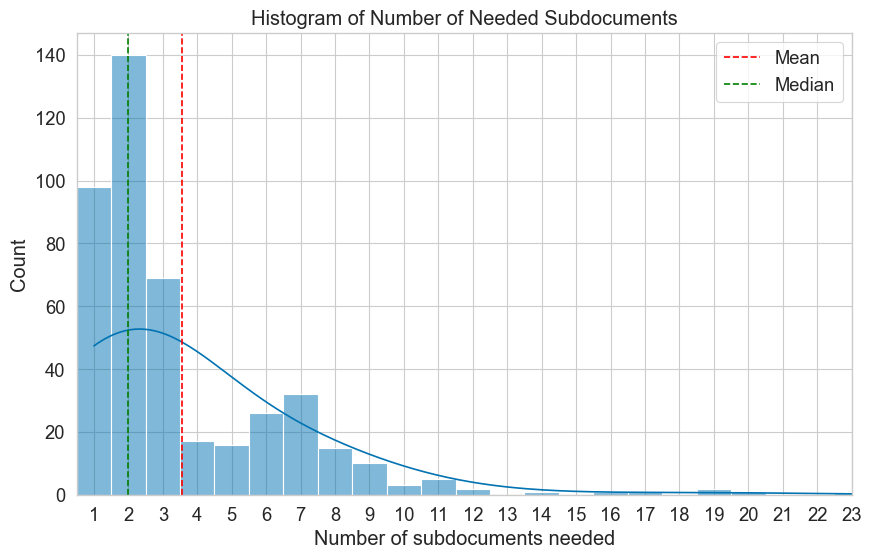

In [8]:
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.5)
sns.set_palette("colorblind")

fig, ax = plt.subplots(figsize=(10, 6))

x = df['num_subdocs'].value_counts().sort_index().index
y = df['num_subdocs'].value_counts().sort_index().values

max_subdocs = max(x)

# add a 0 for each number of subdocs up to the maximum number of subdocs, so that there is a value for each number of subdocs
for i in range(1, max_subdocs+1):
    if i not in x:
        x = np.append(x, i)
        y = np.append(y, 0)

sns.histplot(x=x, weights=y, discrete=True, ax=ax, kde=True)

ax.set(xticks=x)
ax.set_xlim(0.5, max_subdocs)

ax.axvline(x=np.average(x, weights=y), color='red', linestyle='--', label="Mean")

# median calculated manually
z = []
for i in range(len(x)):
    z.extend([x[i]] * y[i])

ax.axvline(x=np.median(z), color='green', linestyle='--', label="Median")

ax.set(xlabel="Number of subdocuments needed")
ax.legend()
ax.set_title("Histogram of Number of Needed Subdocuments")

plt.show()
fig.savefig("plots/subdoc_hist.png", dpi=300)


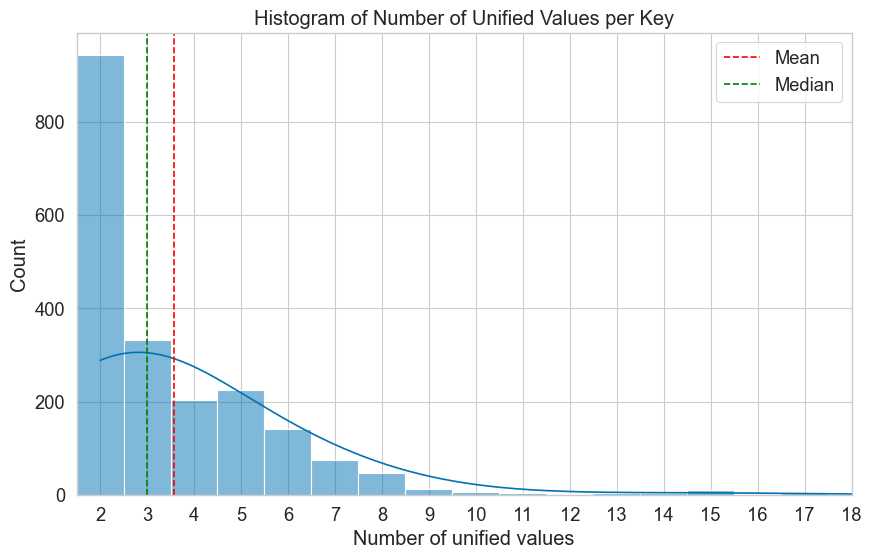

In [9]:
unified_values_per_key = {}

for i in range(len(df)):
    for key, value in df.iloc[i]['num_unified_values_per_key'].items():
        if value is not None and value > 0:
            if key in unified_values_per_key:
                unified_values_per_key[key].append(value)
            else:
                unified_values_per_key[key] = [value]

fig, ax = plt.subplots(figsize=(10, 6))

occurence_dict = {}
for key, values in unified_values_per_key.items():
    for value in values:
        if value in occurence_dict:
            occurence_dict[value] += 1
        else:
            occurence_dict[value] = 1

# intersperse keys that are missing with value 0
for i in range(2, max(occurence_dict.keys())+1):
    if i not in occurence_dict:
        occurence_dict[i] = 0

# sort the dictionary by the key (number of unifications)
occurence_dict = dict(sorted(occurence_dict.items(), key=lambda item: item[0]))

x = list(occurence_dict.keys())
y = list(occurence_dict.values())

sns.histplot(x=x, weights=y, discrete=True, ax=ax, kde=True)

ax.axvline(x=np.average(x, weights=y), color='red', linestyle='--', label="Mean")

# median calculated manually
z = []
for i in range(len(x)):
    z.extend([x[i]] * y[i])

ax.axvline(x=np.median(z), color='green', linestyle='--', label="Median")

ax.set(xticks=x)
ax.set_xlim(1.5, max(x))
ax.set(xlabel="Number of unified values")
ax.set_title("Histogram of Number of Unified Values per Key")
ax.legend()

plt.show()
fig.savefig("plots/unified_values_vs_occurence.png", dpi=300)

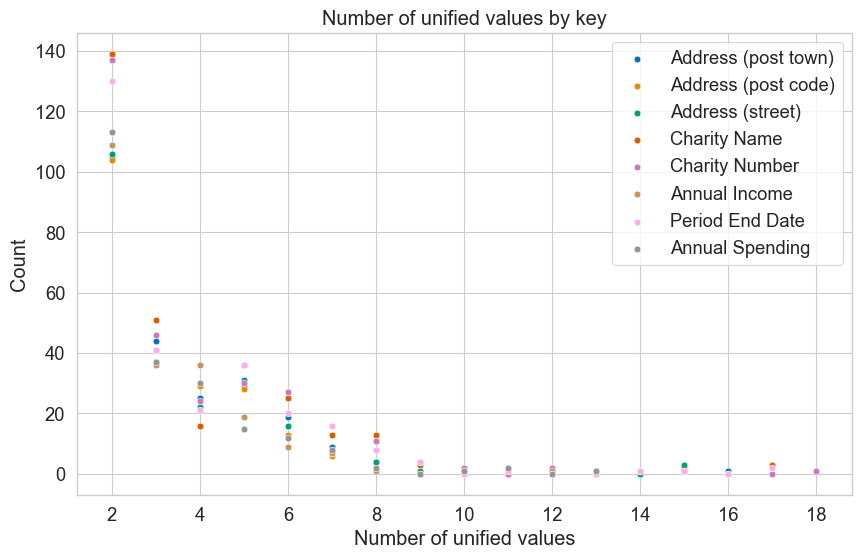

In [10]:
unified_values_per_key = {}

for i in range(len(df)):
    for key, value in df.iloc[i]['num_unified_values_per_key'].items():
        if value is not None and value > 0:
            if key in unified_values_per_key:
                unified_values_per_key[key].append(value)
            else:
                unified_values_per_key[key] = [value]

fig, ax = plt.subplots(figsize=(10, 6))

# one key = one bar plot (histogram)
for key, values in unified_values_per_key.items():
    occurence_dict = {}
    for value in values:
        if value in occurence_dict:
            occurence_dict[value] += 1
        else:
            occurence_dict[value] = 1

    # intersperse keys that are missing with value 0
    for i in range(2, max(occurence_dict.keys())+1):
        if i not in occurence_dict:
            occurence_dict[i] = 0

    # sort the dictionary by the key (number of unifications)
    occurence_dict = dict(sorted(occurence_dict.items(), key=lambda item: item[0]))

    x = list(occurence_dict.keys())
    y = list(occurence_dict.values())

    ax = sns.scatterplot(x=x, y=y, ax=ax, label=key)

ax.set(xlabel="Number of unified values", ylabel="Count")
ax.legend()
ax.set_title("Number of unified values by key")

plt.show()
fig.savefig("plots/unified_values_by_key_vs_count.png", dpi=300)

/Users/ivo/Library/Caches/pypoetry/virtualenvs/uni-kie-JrmAaldC-py3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ivo/Library/Caches/pypoetry/virtualenvs/uni-kie-JrmAaldC-py3.8/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


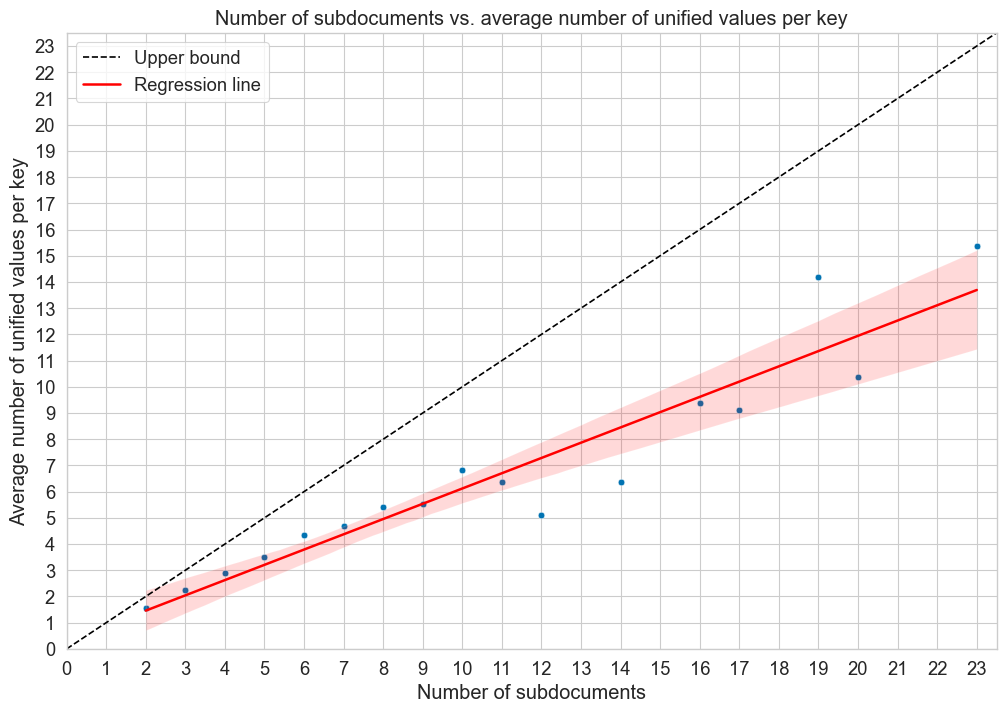

Correlation coefficient: 0.948


In [11]:
fig, ax = plt.subplots(figsize=(12, 8))

max_subdocs = max(df['num_subdocs'])

x = np.arange(0, max_subdocs+1)
y = [] # number of unified values per key (average over all keys)

y = [[] for _ in range(max(x)+1)]

for i in range(len(df)):
    num_subdocs = df.iloc[i]['num_subdocs']
    if num_subdocs == 1:
        continue


    num_unified_values = 0
    num_keys = 0
    for key, value in df.iloc[i]['num_unified_values_per_key'].items():
        if value is not None and value > 0:
            num_unified_values += value
            num_keys += 1
    if num_keys > 0:
        y[num_subdocs].append(num_unified_values / num_keys)
    else:
        y[num_subdocs].append(0)

y = [np.mean(y[i]) for i in range(len(y))] # average number of unified values per key for each number of subdocuments

ax.plot([0, max(x) + 1], [0, max(x) + 1], color='black', linestyle='--', label='Upper bound')

ax = sns.scatterplot(x=x, y=y, ax=ax)

sns.regplot(x=x, y=y, ax=ax, scatter=False, color='red', label='Regression line')

ax.set(xticks=x, yticks=x)
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ax.set_xlim(right=max_subdocs+0.5)
ax.set_ylim(top=max_subdocs+0.5)

# remove nan values from x and y
x = [x[i] for i in range(len(x)) if not np.isnan(y[i])]
y = [y[i] for i in range(len(y)) if not np.isnan(y[i])]


ax.set(xlabel="Number of subdocuments", ylabel="Average number of unified values per key")
ax.legend(loc='upper left')
ax.set_title("Number of subdocuments vs. average number of unified values per key")

plt.show()
fig.savefig("plots/num_subdocs_vs_unified_values_per_key.png", dpi=300)

print("Correlation coefficient: " + str(round(np.corrcoef(x, y)[0, 1], 3)))

Total number of keys that were unified in some way: 2016


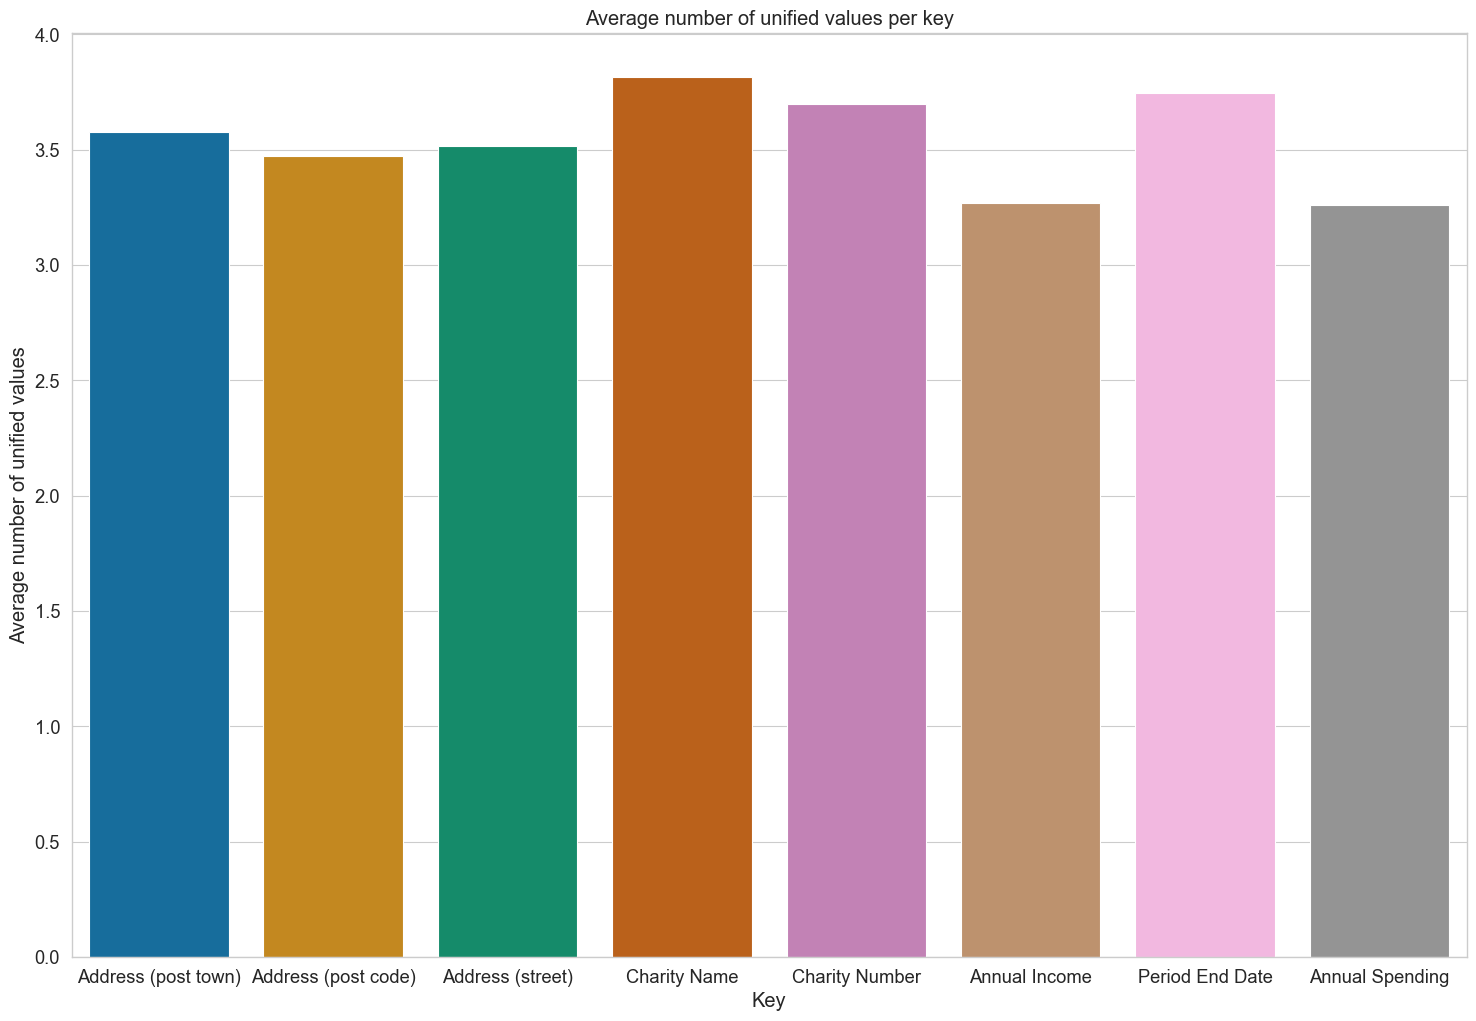

In [12]:
print(f"Total number of keys that were unified in some way: {sum(df['num_unifications'])}")

fig, ax = plt.subplots(figsize=(18, 12))

x = []
y = []

for key, values in unified_values_per_key.items():
    x.append(key)
    y.append(sum(values)/len(values))

ax = sns.barplot(x=x, y=y, ax=ax)

ax.set(xlabel="Key", ylabel="Average number of unified values")
ax.set_title("Average number of unified values per key")

plt.show()
fig.savefig("plots/avg_unified_values_per_key.png", dpi=300)


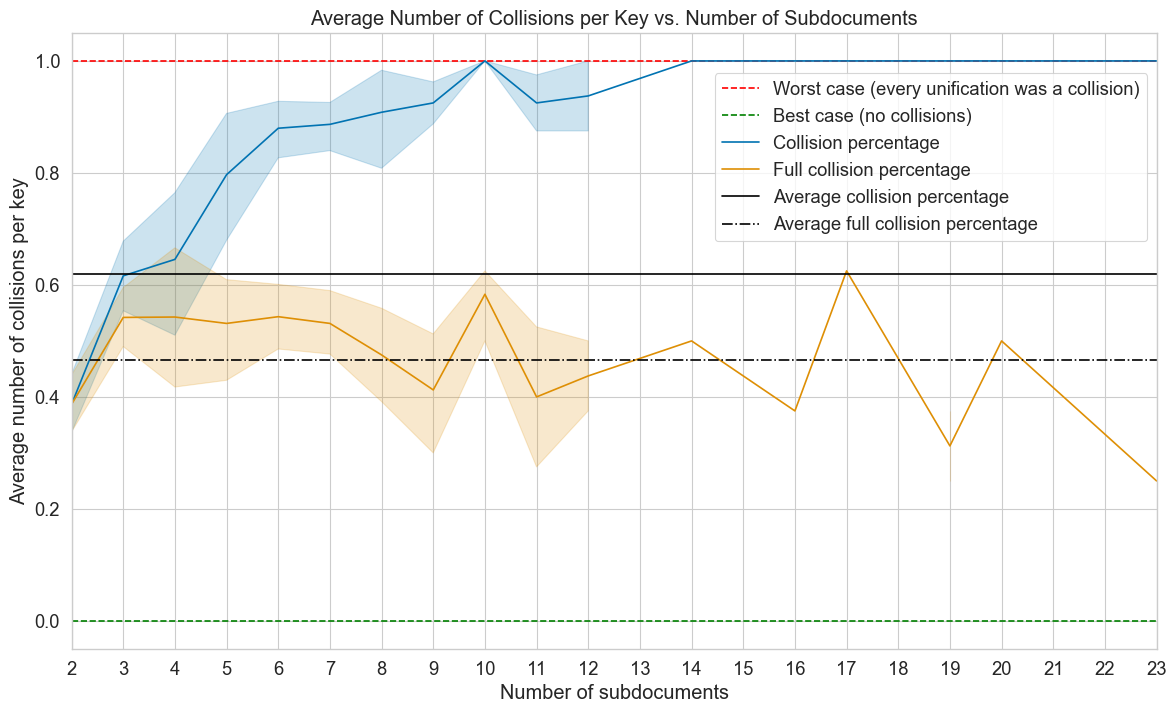

In [13]:
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.5)
sns.set_palette("colorblind")

fig, ax = plt.subplots(figsize=(14, 8))

ax.axhline(y=1, color="red", linestyle="--", label="Worst case (every unification was a collision)")
ax.axhline(y=0, color="green", linestyle="--", label="Best case (no collisions)")

ax = sns.lineplot(x="num_subdocs", y="collision_percentage", data=df, ax=ax, label="Collision percentage")
ax = sns.lineplot(x="num_subdocs", y="full_collision_percentage", data=df, ax=ax, label="Full collision percentage")

avg_collision_percentage = np.nanmean(df['collision_percentage'])
ax.axhline(y=avg_collision_percentage, color="black", linestyle="-", label="Average collision percentage")

avg_full_collision_percentage = np.nanmean(df['full_collision_percentage'])
ax.axhline(y=avg_full_collision_percentage, color="black", linestyle="-.", label="Average full collision percentage")

ax.set_xlim(left=2, right=max(df['num_subdocs']))
ax.set(xticks=np.arange(2, max_subdocs+1, 1))
ax.set(xlabel="Number of subdocuments", ylabel="Average number of collisions per key", title="Average Number of Collisions per Key vs. Number of Subdocuments")
ax.legend(loc='upper right', bbox_to_anchor=(1.0, 0.95))

plt.show()

fig.savefig("plots/collisions_wrt_subdocs_hist.png", dpi=300)

1 subdocument == no subdocs (or in other words: the 1 subdoc is the whole document)

Note: best case assumes:
* perfect OCR
* no mistakes in the reports (no typos, no conflicting information on different pages)

of course with num_subdocs=2 every collision is a full_collision :) 

                     collision_percentage  full_collision_percentage
Address (post town)              0.536050                   0.278997
Address (post code)              0.692063                   0.600000
Address (street)                 0.712934                   0.599369
Charity Name                     0.575668                   0.240356
Charity Number                   0.795858                   0.642012
Annual Income                    0.684543                   0.649842
Period End Date                  0.418398                   0.163205
Annual Spending                  0.677215                   0.658228


ValueError: Could not interpret input 'variable'

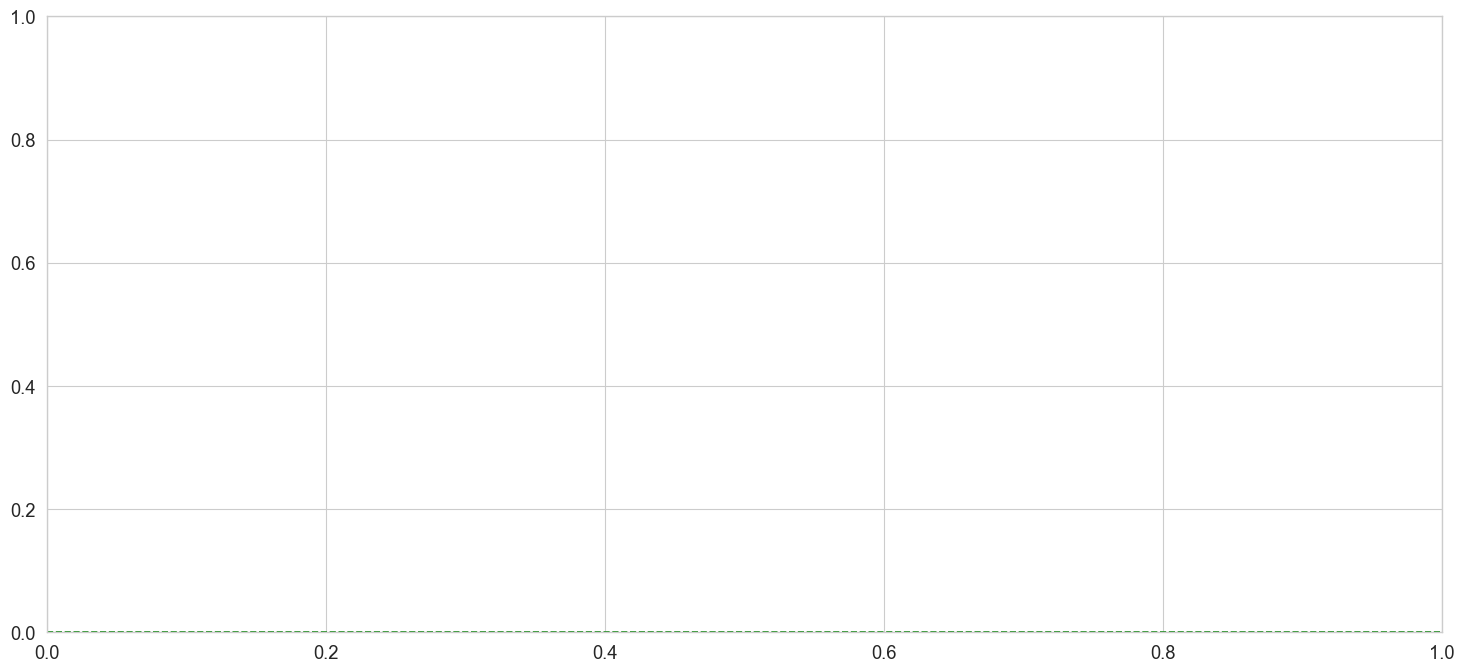

In [14]:
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.5)
sns.set_palette("colorblind")

fig, ax = plt.subplots(figsize=(18, 8))

ax.axhline(y=1, color="red", linestyle="--", label="Worst case (every unification was a collision)")
ax.axhline(y=0, color="green", linestyle="--", label="Best case (no collisions)")

collision_percentage_by_key = {}
full_collision_percentage_by_key = {}

# line plot of the collision percentage by key
for key in df['num_unified_values_per_key'].iloc[0].keys():
    for i in range(len(df)):
        if key not in collision_percentage_by_key:
            collision_percentage_by_key[key] = []

        if key not in full_collision_percentage_by_key:
            full_collision_percentage_by_key[key] = []

        collision_percentage_by_key[key].append(df['collision_per_key'].iloc[i][key])
        full_collision_percentage_by_key[key].append(df['full_collision_per_key'].iloc[i][key])

# filter out None values
collision_percentage_by_key = {key: [x for x in collision_percentage_by_key[key] if x is not None] for key in collision_percentage_by_key.keys()}
full_collision_percentage_by_key = {key: [x for x in full_collision_percentage_by_key[key] if x is not None] for key in full_collision_percentage_by_key.keys()}

# calculate average and ignore nan values
collision_percentage_by_key = {key: np.nanmean(collision_percentage_by_key[key]) for key in collision_percentage_by_key}
full_collision_percentage_by_key = {key: np.nanmean(full_collision_percentage_by_key[key]) for key in full_collision_percentage_by_key}

# create a single dataframe from the two dicts (should be len(keys) and have columns for collision_percentage and full_collision_percentage)
df_collision_percentage_by_key = pd.DataFrame.from_dict(collision_percentage_by_key, orient='index', columns=['collision_percentage'])
df_full_collision_percentage_by_key = pd.DataFrame.from_dict(full_collision_percentage_by_key, orient='index', columns=['full_collision_percentage'])

df_collision_percentage_by_key = df_collision_percentage_by_key.merge(df_full_collision_percentage_by_key, left_index=True, right_index=True)

print(df_collision_percentage_by_key)

ax = sns.barplot(data=df_collision_percentage_by_key, y=df_collision_percentage_by_key.index, hue="variable", orient="h", ax=ax)

avg_collision_percentage = np.nanmean(list(collision_percentage_by_key.values()))
print(f"Average collision percentage: {avg_collision_percentage}")
print(list(collision_percentage_by_key.values()))
ax.axhline(y=avg_collision_percentage, color="black", linestyle="-", label="Average collision percentage")

avg_full_collision_percentage = np.nanmean(list(full_collision_percentage_by_key.values()))
print(f"Average full collision percentage: {avg_full_collision_percentage}")
print(list(full_collision_percentage_by_key.values()))
ax.axhline(y=avg_full_collision_percentage, color="black", linestyle="-.", label="Average full collision percentage")

ax.set(xlabel="Key", ylabel="Average number of (full) collisions", title="Average Number of Collisions by Key")
ax.legend(loc='upper right', bbox_to_anchor=(1.0, 0.95))

plt.show()
fig.savefig("plots/collisions_wrt_key_hist.png", dpi=300)